# Classification using Quantum Support Vector Machines - Breast Cancer data

This notebook applies the quantum support vector machine algorithm to the bread cancer data. 

Previously, I explored the quantum SVM algorithm on an ad-hoc data set created by Qiskit. 

I will still use their `datasets.py` to do some data parsing for us to ensure that the data is in the right shape with the right number of features, however, this time we will be using a real dataset.

In [1]:
from scripts.datasets import *
%matplotlib inline
from scripts.QC_helper import *

from qiskit.aqua.utils import split_dataset_to_data_and_labels
from qiskit.aqua.utils import map_label_to_class_name
from qiskit.aqua.input import ClassificationInput

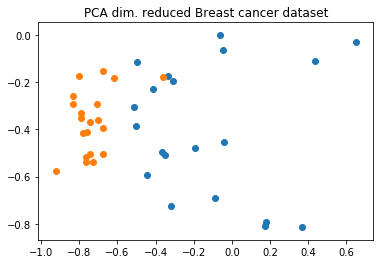

In [2]:
feature_dim = 2
seed = 10598
sample_Total, training_input, test_input, class_labels = Breast_cancer(training_size = 20,
                                                                      test_size = 10,
                                                                      n = 2,
                                                                      PLOT_DATA = True)

In [3]:
# construct the map using second order expansion 
# https://en.wikipedia.org/wiki/Polynomial_kernel
feature_map = SecondOrderExpansion (feature_dimension = feature_dim,
                                   depth = 2,
                                   entanglement = 'linear')

In [4]:
# establish backend (in Aer) and quantum instance :
qsvm = QSVM(feature_map, training_input, test_input)
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots = 1024, seed = seed,
                                  seed_transpiler = seed)

In [5]:
# run the QSVM using the quantum instance created
qsvm_results = qsvm.run(quantum_instance)

In [6]:
# look at the success rate 
print(f"Sucess Ratio (0-1) = {qsvm_results['testing_accuracy']}")

Sucess Ratio (0-1) = 0.8


We were able to achieve a success rate of **80%** in our test data. This number may go up or down depending on the number of test cases. However, we are more interested in the circuits rather than the success rate (for now). 

Training Kernel Matrix


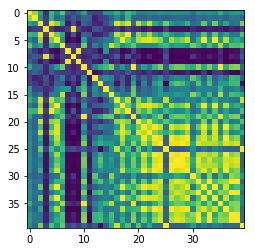

In [7]:
# look at the kernal matrix during training 
print("Training Kernel Matrix")
kernel_matrix = qsvm_results['kernel_matrix_training']
kernel_matrix_plot = plt.imshow(np.asmatrix(kernel_matrix))
plt.show()

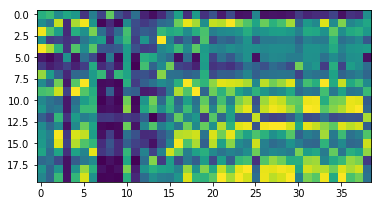

In [8]:
# for comparision, let see the testing kernal matrix
test_kernel_matrix = qsvm_results['kernel_matrix_testing']
test_kernel_plot = plt.imshow(np.asmatrix(test_kernel_matrix))

In [9]:
# let's look at the training input data
print(training_input)

{'A': array([[-0.19172231, -0.48047638],
       [-0.08931675, -0.69047276],
       [-0.50124222, -0.38404633],
       [-0.04524656, -0.06299861],
       [-0.36503477, -0.4966686 ],
       [-0.44318575, -0.59164354],
       [-0.4146524 , -0.22790637],
       [ 0.18070867, -0.79119457],
       [-0.05916688, -0.00087508],
       [ 0.17702071, -0.80782303],
       [-0.33656083, -0.17191985],
       [ 0.43561957, -0.10878753],
       [ 0.3697556 , -0.81262249],
       [ 0.65356721, -0.03027689],
       [-0.04118997, -0.45214114],
       [-0.49742204, -0.11441314],
       [-0.51335869, -0.30515363],
       [-0.31666169, -0.72652614],
       [-0.35047551, -0.5085641 ],
       [-0.30704169, -0.19348554]]), 'B': array([[-0.80381589, -0.17496736],
       [-0.8333448 , -0.25876499],
       [-0.70730804, -0.29054463],
       [-0.79008762, -0.3313085 ],
       [-0.67599686, -0.50282222],
       [-0.67547425, -0.15140441],
       [-0.79041979, -0.352277  ],
       [-0.78150554, -0.41353571],
       

## Parsing and exploring the data
Before we generate any quantum circuits, we have to realize that there are only two classes, and two features. 

The class labels are `A` and `B`. Let's seperate the classes.
We do this so that our quantum circuits will have an even mixture of both classes.

Let's split the training input data.

In [10]:
A_training_data = training_input.get('A')
B_training_data = training_input.get('B')

## Drawing the quantum circuits

For now, let's say we want to see only 4 circuits. 

In [13]:
num_desired_circuits = 4
breast_cancer_qc_data = prepare_data_set_for_qc(num_desired_circuits,
                                               A_training_data,
                                               B_training_data)
draw_circuits(qsvm, breast_cancer_qc_data)

Circuit for: x(0) transpose * x(0)
circuit info:
	circuit depth =  20 	circuit width =  4
Circuit operation breakdown:
	 {'u2': 8, 'u1': 12, 'cx': 8}
        ┌──────────┐┌──────────────┐                        ┌──────────┐»
q_0: |0>┤ U2(0,pi) ├┤ U1(-0.38344) ├──■──────────────────■──┤ U2(0,pi) ├»
        ├──────────┤├──────────────┤┌─┴─┐┌────────────┐┌─┴─┐├──────────┤»
q_1: |0>┤ U2(0,pi) ├┤ U1(-0.96095) ├┤ X ├┤ U1(24.147) ├┤ X ├┤ U2(0,pi) ├»
        └──────────┘└──────────────┘└───┘└────────────┘└───┘└──────────┘»
 c_0: 0 ════════════════════════════════════════════════════════════════»
                                                                        »
 c_1: 0 ════════════════════════════════════════════════════════════════»
                                                                        »
«     ┌──────────────┐                                                 »
«q_0: ┤ U1(-0.38344) ├──■──────────────────■────■───────────────────■──»
«     ├──────────────┤┌─┴─┐┌──────────

### Important note: `U2(0,pi)` = `U2(-2*pi,pi)` = Hadamard gate 